In [2]:
import numpy as np
import pprint
import networkx as nx
import math 
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import cluster, datasets
np.random.seed(0)
n_samples = 400
X, y = datasets.make_circles(n_samples=n_samples, factor=.4, noise=.1)

In [3]:
len(X[:,0])

400

In [4]:
import seaborn as sns

In [5]:
from qiskit import IBMQ
IBMQ.save_account('3ccb2d17a0f19c3ce64cf44b3e1c90d3369ea562672f7315624ee8d92bb4350e10b643e3b2af92eef73c029e051518c2a833fb0ffa2e600b2c6c65ed5dd29d40')
IBMQ.load_account()
from qiskit import *
import math as m
import time
from copy import deepcopy
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.quantum_info import state_fidelity
#simulators
S_simulator = Aer.backends(name = 'statevector_simulator')[0]
M_simulator = Aer.backends(name = 'qasm_simulator')[0]
U_simulator = Aer.backends(name = 'unitary_simulator')[0]
#provider = IBMQ.get_provider(hub = 'ibm-q-research')

configrc.store_credentials:WARNING:2023-01-21 00:12:37,502: Credentials already present. Set overwrite=True to overwrite.


Text(0, 0.5, '$y$')

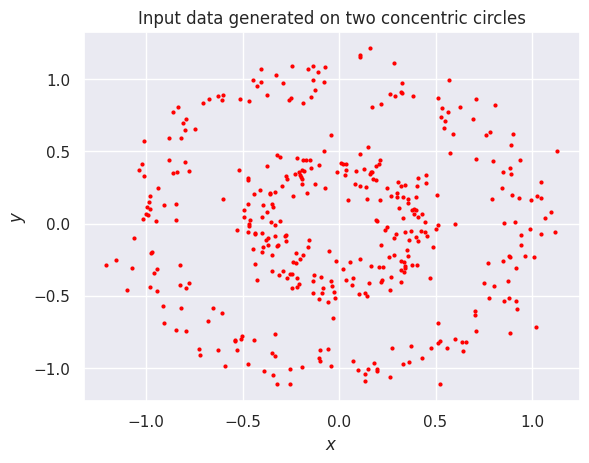

In [6]:
#sns.despine()
#sns.set_style('white')
sns.set_theme()
plt.title("Input data generated on two concentric circles")
for i in range(len(X[:,0])):
    plt.scatter(X[:,0][i],X[:,1][i], s = 4, c = 'red')
plt.xlabel("$x$")
plt.ylabel("$y$")



In [7]:
dist_from_origin = []
def distance_from_origin(x1,y1):
    return (x1**2 + y1**2)**(1/2)
for i in range(len(X[:,0])):
    dist_from_origin.append(distance_from_origin(X[:,0][i],X[:,1][i])) 
for i in range(400):
    dist_from_origin[i] = dist_from_origin[i]*10
print(max(dist_from_origin))

12.483369566118885


In [8]:
def decimalToBinary(n,N):  # bin returns the binary representation of an integer.  n is the input decimal and N is the length of the string 
    bin1=bin(n).replace("0b", "")
    bin2='0'*(N-len(bin1))+bin1
    return bin2

In [9]:
def binaryToDecimal(binary):
     
    binary1 = binary
    decimal, i, n = 0, 0, 0
    while(binary != 0):
        dec = binary % 10
        decimal = decimal + dec * pow(2, i)
        binary = binary//10
        i += 1
    print(decimal) 

In [10]:

nq = int(math.log(max(dist_from_origin),2))+ 1  # representing the distances in terms of qubit 
int_list_dist=[int(i) for i in dist_from_origin]
bin_dist = [decimalToBinary(i,nq) for i in int_list_dist] # all the distances from city k1 = 14 in binary form 
print(type(len(int_list_dist)))
print(len(bin_dist))  # left one is the most significant bit 

<class 'int'>
400


In [11]:
nq = int(math.log(max(dist_from_origin),2))+1 # number of qubits 
x1= np.zeros(2**nq,dtype = int) # x1 is an empty array 
for i in range(2**nq):    # i ranges from 0 to 2**N = 16384, 2^N also represents the range of distance
    if i in int_list_dist: # if the distance is in int_list_distance(which is the distance of each city from k1 city) then x1[i] = 1
        x1[i]=1
x1=x1/len(x1.nonzero()[0])

In [12]:
int('0011',2)

3

In [13]:
x2=x1.reshape(2**nq)
x2= x2/np.linalg.norm(x2)

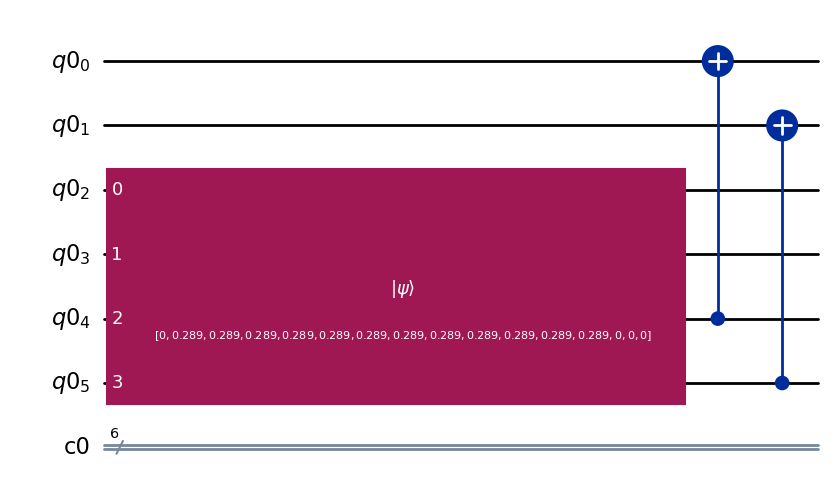

In [14]:
num_clusters = 3
M = int(math.log(num_clusters,2)) +1 # based on clusters 
M
c = ClassicalRegister(nq+M)
# we have N qubits and all are in state x2
# and we apply controlled not to rest of the M qubits(ancillas).
#quantum circuit
q=QuantumRegister(nq+M) # 18 qubits 
#c=ClassicalRegister(N+M)
qc = QuantumCircuit(q,c)
qc.initialize(x2, [i+M for i in range(nq)]) # prepare x2 state on the first 8 qubits  
# qc.initialize(params, qubits=None)
# qubits = quantumregister or a list. these are genreally qubits that are to be initialized
for j in range(M):
    qc.cx(nq+j,j)

job = execute(qc, backend=S_simulator, optimization_level=0)
psi_block2 = job.result().get_statevector(qc, decimals=16) # gives the final statevector of the experiment upto 16 decimal places

qc.draw('mpl', style = 'iqx')

In [15]:
qc.measure(range(nq+M),range(nq+M)) # this is a way to do all the qc.measure(qr8[j],cr8[j]) at once

qobj = assemble(qc, shots=8125)
Counts = S_simulator.run(qobj).result().get_counts()

In [17]:
list1=[] # list1 is the list that contains the position of elements in the statevector whose value is greater than 10^-16
list2=[]
for j in range(len(psi_block2)):        
    if abs(psi_block2[j])> 10**(-16): # abs: returns the absolute value of the argument  # why this step? # these are the cities ig
        list1.append(j)
        list2.append(abs(psi_block2[j]))
print(list1)

[4, 8, 12, 17, 21, 25, 29, 34, 38, 42, 46, 51]


In [18]:
anc_key = list(set([list(Counts.keys())[i][nq:nq+M] for i in range(len(list(Counts.keys())))])) ## last 4 qubits are for the clusters which is bascically ancilla qubits 
List_cluster=[]
for i in range(len(anc_key)):
    cluster=[]
    for j in range(len(list(Counts.keys()))):
        if anc_key[i] == list(Counts.keys())[j][nq:nq+M]:
            cluster.append(list(Counts.keys())[j][0:nq])
    List_cluster.append(cluster)


In [19]:
decimal_cluster_1 = []
decimal_cluster_2 = []
decimal_cluster_3 = []
decimal_cluster_4 = []

for i in range(len(List_cluster[0])):
    decimal_cluster_1.append(int(List_cluster[0][i],2))

for i in range(len(List_cluster[1])):
    decimal_cluster_2.append(int(List_cluster[1][i],2))

for i in range(len(List_cluster[2])):
    decimal_cluster_3.append(int(List_cluster[2][i],2))

for i in range(len(List_cluster[3])):
    decimal_cluster_4.append(int(List_cluster[3][i],2))

decimal_cluster_1.sort()
decimal_cluster_2.sort()
decimal_cluster_3.sort()
decimal_cluster_4.sort()

print(decimal_cluster_1)
print(decimal_cluster_2)
print(decimal_cluster_3)
print(decimal_cluster_4)

[12]
[4, 5, 6, 7]
[8, 9, 10, 11]
[1, 2, 3]


In [20]:
fin_cluster_1 =[]
fin_cluster_2 =[]
fin_cluster_3 =[]
fin_cluster_4 =[]

for j in range(len(dist_from_origin)):
    for i in decimal_cluster_1:
        if i-1 < dist_from_origin[j] < i+1:
            fin_cluster_1.append(dist_from_origin[j])

for j in range(len(dist_from_origin)):
    for i in decimal_cluster_2:
        if i-1 < dist_from_origin[j] < i+1:
            fin_cluster_2.append(dist_from_origin[j])

for j in range(len(dist_from_origin)):
    for i in decimal_cluster_3:
        if i-1 < dist_from_origin[j] < i+1:
            fin_cluster_3.append(dist_from_origin[j])

for j in range(len(dist_from_origin)):
    for i in decimal_cluster_4:
        if i-1 < dist_from_origin[j] < i+1:
            fin_cluster_4.append(dist_from_origin[j])

fin_cluster_1.sort()
fin_cluster_2.sort()
fin_cluster_3.sort()
fin_cluster_4.sort()

print(len(set(fin_cluster_1)))
print(len(set(fin_cluster_2)))
print(len(set(fin_cluster_3)))
print(len(set(fin_cluster_4)))

33
179
195
86


In [21]:
clust_1 = list(set(fin_cluster_1 + fin_cluster_3) )
clust_2 = list(set(fin_cluster_2 + fin_cluster_4) )

In [22]:
cl = []
for j in range(len(clust_1)):
    for i in range(400):
        if 10*((X[:,0][i])**2 + (X[:,1][i])**2)**(1/2) == clust_1[j]  :
            cl.append([X[:,0][i],X[:,1][i]])
#print(cl)
cl_2 = []
for j in range(len(clust_2)):
    for i in range(400):
        if 10*((X[:,0][i])**2 + (X[:,1][i])**2)**(1/2) == clust_2[j]  :
            cl_2.append([X[:,0][i],X[:,1][i]])


Text(0, 0.5, '$y$')

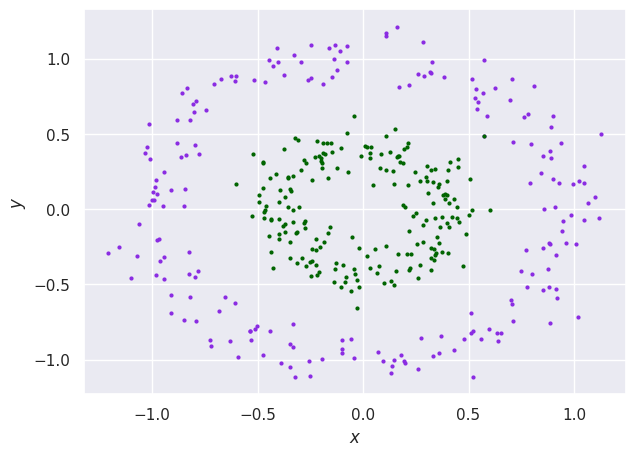

In [31]:
sns.set_theme()
plt.figure(figsize=(7, 5))  
#plt.title('Data after forming clusters')
for i in range(len(clust_1)):
    plt.scatter(cl[i][0], cl[i][1], s = 4, c = 'blueviolet')
for i in range(len(clust_2)):
    plt.scatter(cl_2[i][0], cl_2[i][1], s = 4, c = 'darkgreen')
plt.xlabel("$x$")
plt.ylabel("$y$")